In [8]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from timeit import timeit
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.image import imread
import urllib
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


### Importa los datos
Dataset con diferentes fármacos, sus efectos y ratings de los clientes.

Importa el dataset *drugLibTrain_raw.tsv*

In [9]:
df = pd.read_csv('data/drugLibTrain_raw.tsv', sep = '\t')

In [10]:
df

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...,...
3102,1039,vyvanse,10,Highly Effective,Mild Side Effects,adhd,"Increased focus, attention, productivity. Bett...","Restless legs at night, insomnia, headache (so...","I took adderall once as a child, and it made m..."
3103,3281,zoloft,1,Ineffective,Extremely Severe Side Effects,depression,Emotions were somewhat blunted. Less moodiness.,"Weight gain, extreme tiredness during the day,...",I was on Zoloft for about 2 years total. I am ...
3104,1664,climara,2,Marginally Effective,Moderate Side Effects,total hysterctomy,---,Constant issues with the patch not staying on....,---
3105,2621,trileptal,8,Considerably Effective,Mild Side Effects,epilepsy,Controlled complex partial seizures.,"Dizziness, fatigue, nausea",Started at 2 doses of 300 mg a day and worked ...


### Descriptive Analysis

Quedate únicamente con las columnas que podamos manejar: Columnas numéricas y columnas categóricas con pocas categorías (menos de 10)

In [11]:
import pandas as pd

num_cols = df.select_dtypes(include='number').columns

cat_cols = [col for col in df.select_dtypes(exclude='number').columns if df[col].nunique() < 10]

filtered_df = df[num_cols.union(cat_cols)]

filtered_df

,Unnamed: 0,effectiveness,rating,sideEffects
0,2202,Highly Effective,4,Mild Side Effects
1,3117,Highly Effective,1,Severe Side Effects
2,1146,Highly Effective,10,No Side Effects
3,3947,Marginally Effective,3,Mild Side Effects
4,1951,Marginally Effective,2,Severe Side Effects
...,...,...,...,...
3102,1039,Highly Effective,10,Mild Side Effects
3103,3281,Ineffective,1,Extremely Severe Side Effects
3104,1664,Marginally Effective,2,Moderate Side Effects
3105,2621,Considerably Effective,8,Mild Side Effects


#### Transforma las columnas categóricas

Transforma las columnas categoricas a numericas mediante dummies

In [12]:
dummies = ['effectiveness', 'sideEffects']

df_dummies = pd.get_dummies(filtered_df, columns=dummies)

In [13]:
# df_dummies.drop(columns='Unnamed: 0', inplace=True)
df_dummies

,Unnamed: 0,rating,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,2202,4,False,True,False,False,False,False,True,False,False,False
1,3117,1,False,True,False,False,False,False,False,False,False,True
2,1146,10,False,True,False,False,False,False,False,False,True,False
3,3947,3,False,False,False,True,False,False,True,False,False,False
4,1951,2,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
3102,1039,10,False,True,False,False,False,False,True,False,False,False
3103,3281,1,False,False,True,False,False,True,False,False,False,False
3104,1664,2,False,False,False,True,False,False,False,True,False,False
3105,2621,8,True,False,False,False,False,False,True,False,False,False


#### Genera el K Means 

#### Evalua cual es la mejor K

Utiliza silhouette_score para evaluar cual es la mejor K.

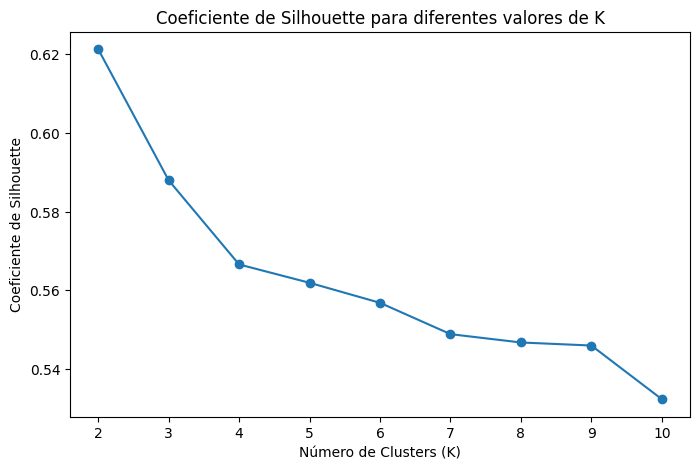

El mejor valor de K según el coeficiente de Silhouette es: 2


In [21]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_dummies)
    score = silhouette_score(df_dummies, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficiente de Silhouette para diferentes valores de K')
plt.show()

best_k = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]
print(f"El mejor valor de K según el coeficiente de Silhouette es: {best_k}")


Comprueba los resultados y muestra en un pie plot la distribución de los distintos clusters.

In [19]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_dummies['Cluster'] = kmeans.fit_predict(df_dummies)
cluster_counts = df_dummies['Cluster'].value_counts()

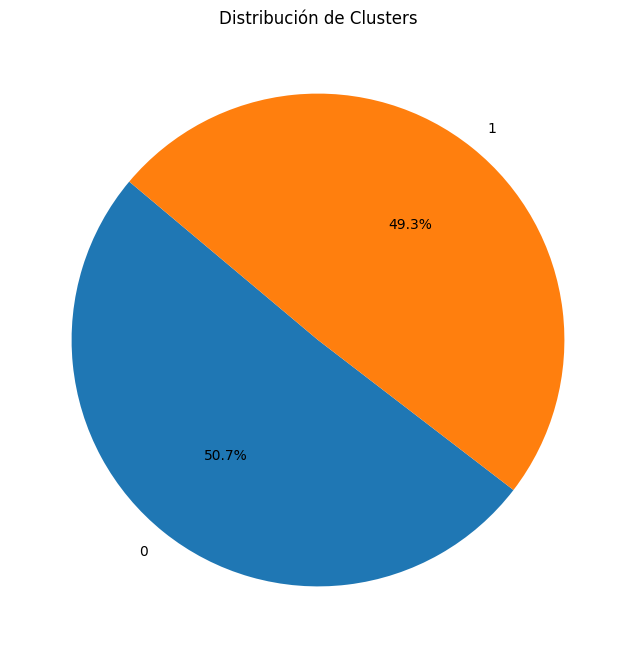

In [20]:
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Clusters')
plt.show()